# Essential Imports

In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
# Define a dictionary to store images and masks
frameObjTrain = {
    'img': [],
    'mask': []
}

# Data Loader Function
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=128):
    imgNames = os.listdir(imgPath)
    
    # Extract unique image base names
    unames = list(set([name.split('_')[0] for name in imgNames]))
    
    # Create lists of image and mask file names
    names = [uname + '_t.png' for uname in unames]
    maskNames = [uname + '_i2.png' for uname in unames]
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    # Load and resize images and masks
    for i in range(len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

# Load the training data

In [3]:
framObjTrain = LoadData(
    frameObjTrain, 
    imgPath='/kaggle/input/earth-terrain-height-and-segmentation-map-images', 
    maskPath='/kaggle/input/earth-terrain-height-and-segmentation-map-images', 
    shape=128
)

# Display Loaded Data

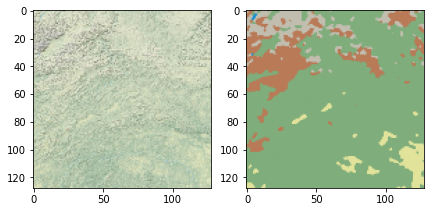

In [4]:
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1, 2, 2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [5]:
# Convolutional Block Function
def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    # First Convolution
    x = tf.keras.layers.Conv2D(
        filters=numFilters, kernel_size=(kernelSize, kernelSize),
        kernel_initializer='he_normal', padding='same'
    )(inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    # Second Convolution
    x = tf.keras.layers.Conv2D(
        filters=numFilters, kernel_size=(kernelSize, kernelSize),
        kernel_initializer='he_normal', padding='same'
    )(x)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

# UNet Model Definition
def GiveMeUnet(inputImage, numFilters=16, droupouts=0.1, doBatchNorm=True):
    # Encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize=3, doBatchNorm=doBatchNorm)
    
    # Decoder Path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputImage], outputs=[output])
    return model

# Instantiate and Compile the Model

In [6]:
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, droupouts=0.07)
myTransformer.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model

In [7]:
retVal = myTransformer.fit(
    np.array(framObjTrain['img']), np.array(framObjTrain['mask']), 
    epochs=50, verbose=0
)

# Plot Training Loss and Accuracy

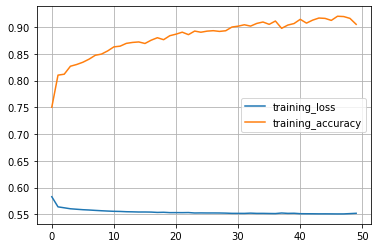

In [8]:
plt.plot(retVal.history['loss'], label='training_loss')
plt.plot(retVal.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Prediction Function for 16 Samples
def predict16(valMap, model, shape=256):
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i][:,:,0], predictions[i][:,:,1], predictions[i][:,:,2]))
    
    return predictions, imgProc, mask

# Plotter Function to Display Predictions
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Terrain Image')
    
    # Image Sharpening
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask, -1, filter)
    
    plt.subplot(1, 3, 2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Terrain Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(groundTruth)
    plt.title('Actual Terrain Mask')
    plt.show()

# Generate and Plot Predictions

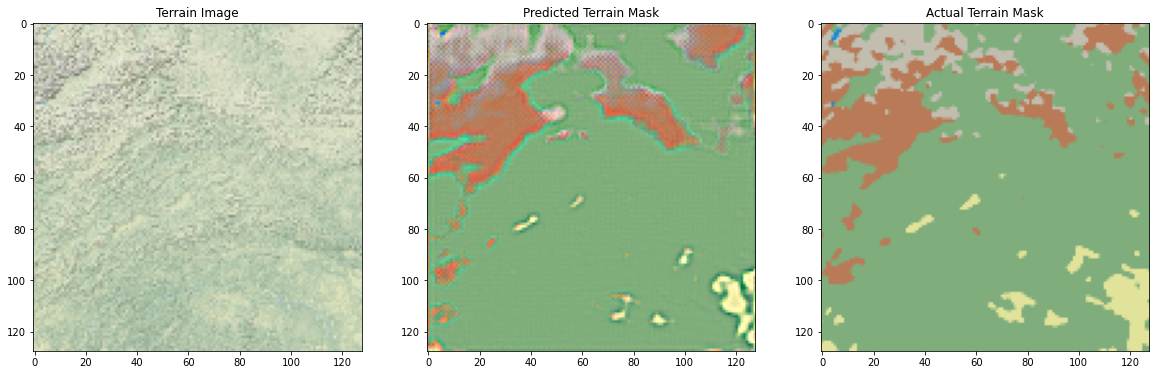

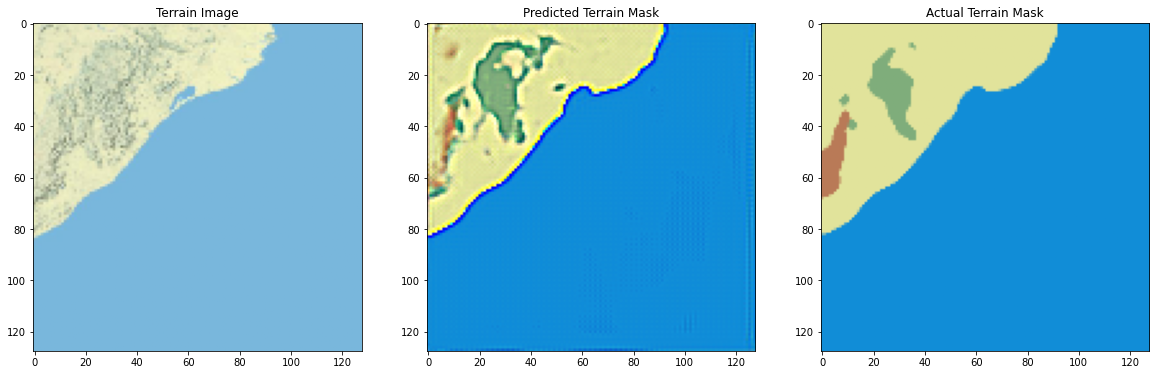

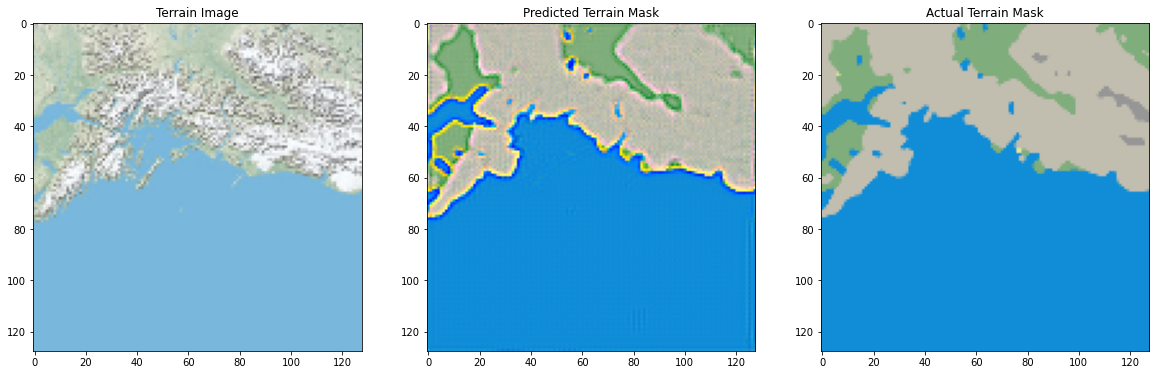

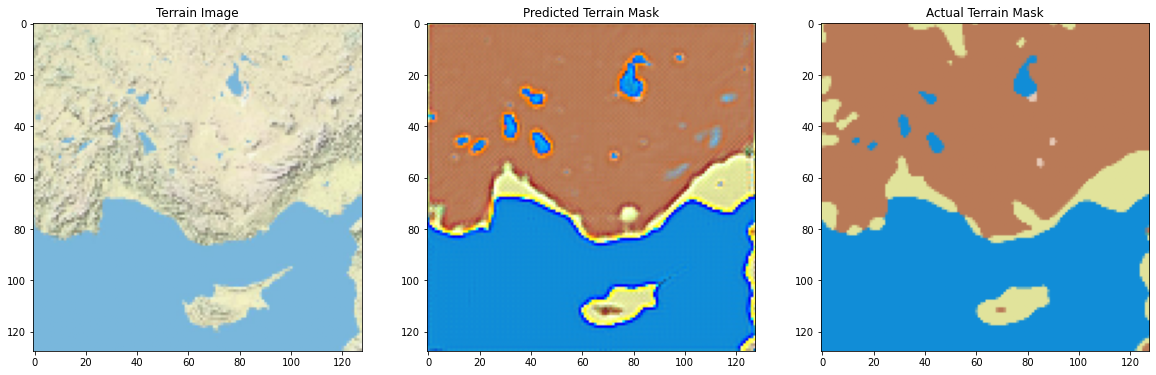

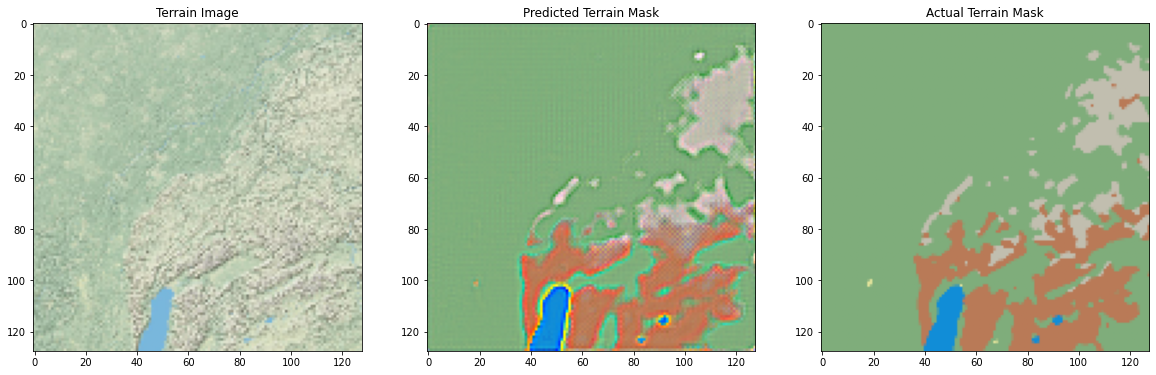

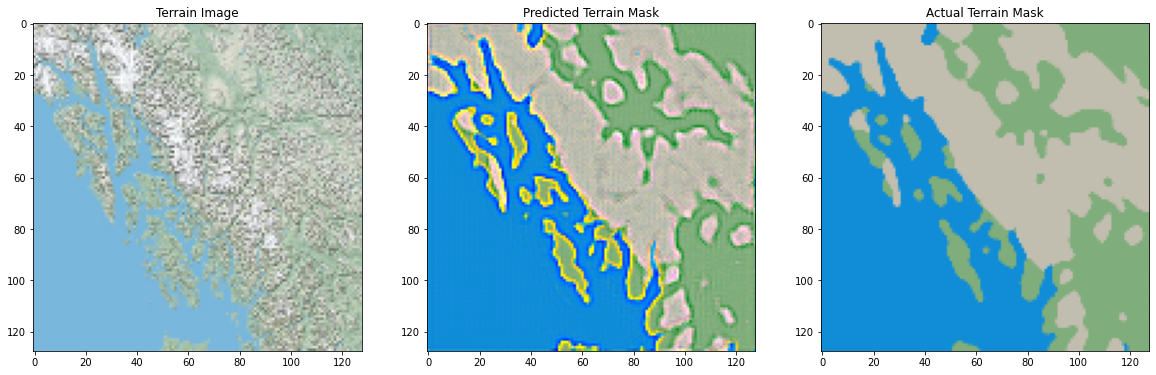

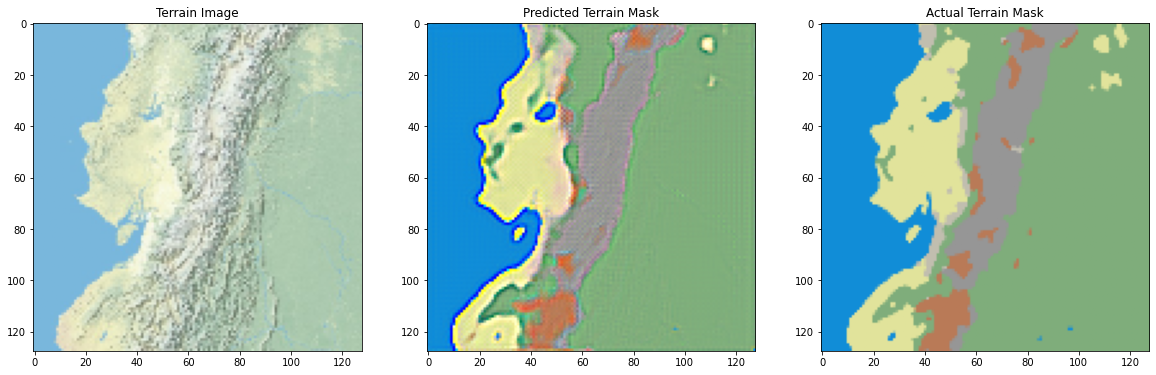

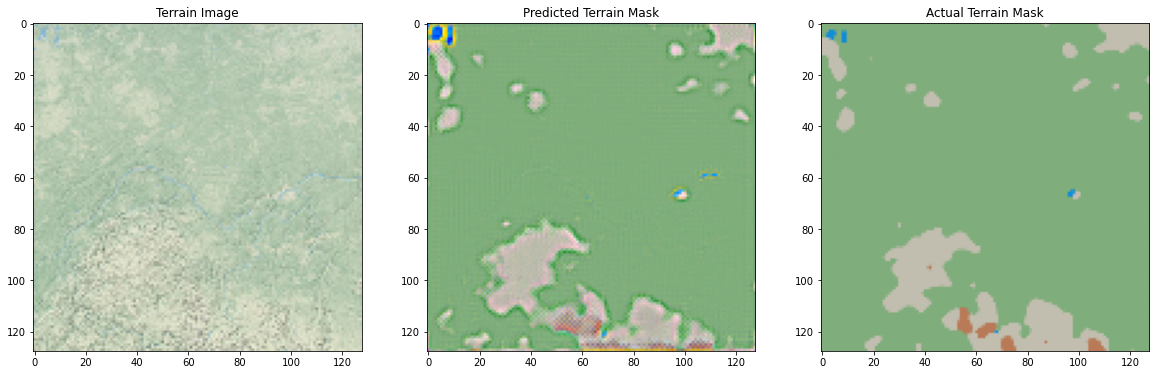

In [10]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
for i in range(1, 9):
    Plotter(actuals[i], sixteenPrediction[i], masks[i])

# Save the Model

In [11]:
myTransformer.save('TerrainMaskGenerator.h5')